In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import shap

In [3]:
df = pd.read_csv("/Users/naveenapaleti/Projects/ShopTrack360/data/customer_features.csv")
X = df.drop(columns=['CustomerID', 'ChurnLabel'])
y = df['ChurnLabel']

In [4]:
# Identify types
num_cols = X.select_dtypes(include=['float64', 'int64']).columns
cat_cols = ['Country']

# Preprocessor
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), cat_cols)
])


# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [5]:
log_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
print(classification_report(y_test, y_pred_log))
print("ROC-AUC:", roc_auc_score(y_test, log_model.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       330
           1       1.00      0.96      0.98       538

    accuracy                           0.98       868
   macro avg       0.97      0.98      0.98       868
weighted avg       0.98      0.98      0.98       868

ROC-AUC: 0.9997972287935113


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [6]:
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1]))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       330
           1       1.00      1.00      1.00       538

    accuracy                           1.00       868
   macro avg       1.00      1.00      1.00       868
weighted avg       1.00      1.00      1.00       868

ROC-AUC: 1.0


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


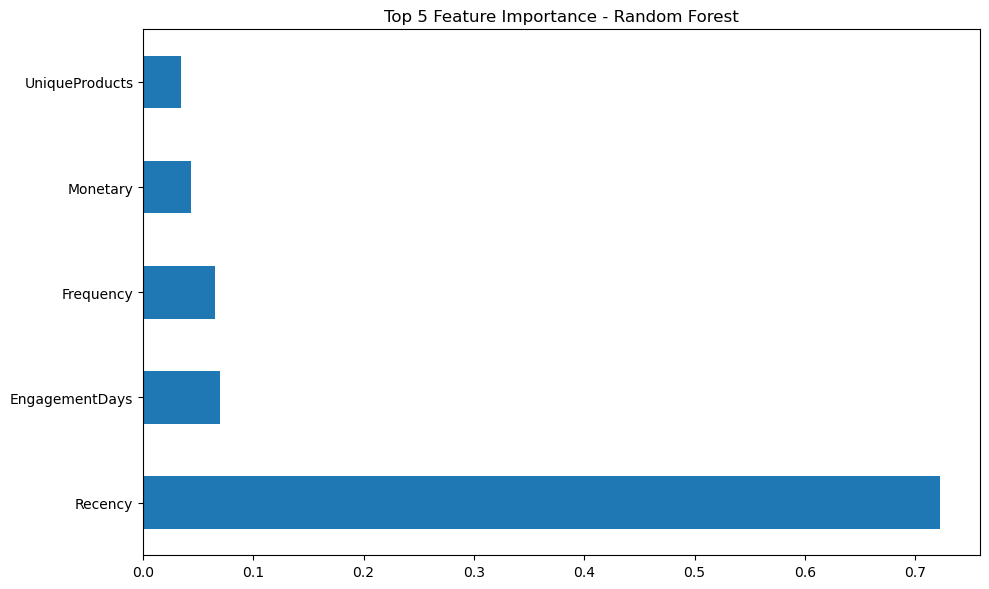

In [7]:
# Get feature names post-transformation
ohe_features = rf_model.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(cat_cols)
feature_names = list(num_cols) + list(ohe_features)

# Extract feature importances
importances = rf_model.named_steps['classifier'].feature_importances_

# Plot
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
x = feat_imp.head()
x.plot(kind='barh', figsize=(10,6), title='Top 5 Feature Importance - Random Forest')
plt.tight_layout()
plt.show()


In [8]:
import joblib
joblib.dump(log_model, '/Users/naveenapaleti/Projects/ShopTrack360/models/churn_model_logreg.pkl')
joblib.dump(rf_model, '/Users/naveenapaleti/Projects/ShopTrack360/models/churn_model_rf.pkl')


['/Users/naveenapaleti/Projects/ShopTrack360/models/churn_model_rf.pkl']

In [9]:
# After model is trained and predictions are made
y_probs = log_model.predict_proba(X_test)[:, 1]
y_preds = log_model.predict(X_test)

# Create DataFrame
churn_predictions = pd.DataFrame({
    'CustomerID': df.loc[X_test.index, 'CustomerID'],  # Optional if ID exists
    'churn_prob': y_probs,
    'churn_pred': y_preds
})

# Save to app/data/ for dashboard use
churn_predictions.to_csv("/Users/naveenapaleti/Projects/ShopTrack360/data/churn_predictions.csv", index=False)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
